# Importancia dos bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import keras
from keras import layers
from skopt import BayesSearchCV
import warnings
import pickle
import warnings
warnings.filterwarnings("ignore")

2024-07-11 01:24:27.620812: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 01:24:27.838967: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 01:24:32.733200: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 01:24:50.723143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 01:25:21.891058: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Importacao dos dados

In [ ]:
dados_tratados = pickle.load(open('dados/dados_tratados.pickle', 'rb'))

In [ ]:
x_treino = dados_tratados['x_treino']
y_treino = dados_tratados['y_treino']
x_teste = dados_tratados['x_teste']
y_teste = dados_tratados['y_teste']

print(x_treino.shape, y_treino.shape, x_teste.shape, y_teste.shape) # x_treino.shape

(59606, 20) (59606,) (15891, 20) (15891,)


# Treinamento do modelo

## Selecionando os modelos 

In [ ]:
## criar a rede seqeuncial

model_rede = Sequential()
model_rede.add(layers.Dense(units=40,activation='relu',input_shape=(20,)))
#model.add(layers.Dropout(0.20))
model_rede.add(layers.Dense(units=60,activation='relu'))
#model.add(layers.Dropout(0.20))
model_rede.add(layers.Dense(units=40,activation='relu'))
#model.add(layers.Dropout(0.20))
model_rede.add(layers.Dense(units=1,activation='sigmoid'))
model_rede.summary()
opt = keras.optimizers.SGD(learning_rate=0.01)
model_rede.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy', 'Recall'])
#epochs_hist = model.fit(x_treino, y_treino.values, epochs=100,batch_size=500)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 40)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 40)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,781 (22.58 KB)

 Trainable params: 5,781 (22.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
##
modelos = {
    'logistic_regression': LogisticRegression(),
    'random_forest': RandomForestClassifier(),
    'gradient_boost': GradientBoostingClassifier(),
    'svc': SVC(),
    'cat_boost': CatBoostClassifier(),
    'redes_sequencial': model_rede
}

from sklearn.metrics import classification_report,recall_score
lista_recall = {}
for key,model in modelos.items():
    if key == 'redes_sequencial': 
        epochs_hist = model.fit(x_treino, y_treino.values, epochs=100,batch_size=500,verbose=0)  
        print('O modelo treinado é o:', key)
        y_pred = model.predict(x_teste).squeeze()
        y_pred_redes = (y_pred > 0.5).astype(int)
        lista_recall[key] = recall_score(y_teste,y_pred_redes)
        print(classification_report(y_teste.values, y_pred_redes))  
        print('----------------------------------------------------')
        
    else:
        model = model
        if key == 'cat_boost':
            model_treinado = model.fit(x_treino, y_treino,verbose=0)
        else:
            model_treinado = model.fit(x_treino, y_treino)
        print('O modelo treinado e de:', key)
        print(key, model_treinado.score(x_teste, y_teste))
        print(classification_report(y_teste, model.predict(x_teste)))
        lista_recall[key] = recall_score(y_teste,model.predict(x_teste))
        print('----------------------------------------------------')


O modelo treinado e de: logistic_regression
logistic_regression 0.9821282486942294
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15518
           1       0.72      0.39      0.51       373

    accuracy                           0.98     15891
   macro avg       0.85      0.70      0.75     15891
weighted avg       0.98      0.98      0.98     15891

----------------------------------------------------
O modelo treinado e de: random_forest
random_forest 0.9887357623812221
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15518
           1       0.90      0.58      0.71       373

    accuracy                           0.99     15891
   macro avg       0.95      0.79      0.85     15891
weighted avg       0.99      0.99      0.99     15891

----------------------------------------------------
O modelo treinado e de: gradient_boost
gradient_boost 0.9879176892580706
             

**Análise dos Resultados**

Os modelos de Boosting parecem ter um desempenho melhor, sendo os três melhores:

Selecionei os seguintes modelos para fazer a tunagem:
- Cat Boost
- Random Forest

Para ter um modelo diferente, o terceiro modelo será a rede sequencial.

In [ ]:
pd.DataFrame(list(lista_recall.items()), columns=['Model', 'Recall']).sort_values(by='Recall', ascending=False)

,Model,Recall
4,cat_boost,0.705094
1,random_forest,0.581769
2,gradient_boost,0.579088
5,redes_sequencial,0.525469
3,svc,0.439678
0,logistic_regression,0.394102


# Tunagem dos modelos

## Cat Boost

In [ ]:
from sklearn.metrics import classification_report,recall_score

In [ ]:
y_pred_redes = model.predict(x_treino).squeeze()

1863/1863 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step


In [ ]:
y_pred_redes

array([0.00571709, 0.00173373, 0.00051002, ..., 0.00040105, 0.00300221,
       0.0010224 ], dtype=float32)

In [ ]:
y_pred_redes = model.predict(x_treino).squeeze()

1863/1863 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step


In [ ]:
y_pred_redes

array([0.0006073 , 0.0004145 , 0.00513976, ..., 0.00186761, 0.00048558,
       0.00038469], dtype=float32)

In [ ]:
recall_score(y_teste, y_pred_redes)

In [ ]:
y_pred_redes = model.predict(x_teste).squeeze()
y_pred_redes_res = (y_pred_redes > 0.1).astype(int)
print(classification_report(y_teste.values, y_pred_redes_res))


497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15518
           1       0.48      0.84      0.61       373

    accuracy                           0.98     15891
   macro avg       0.74      0.91      0.80     15891
weighted avg       0.98      0.98      0.98     15891



In [ ]:
recall_score(y_teste)

0.839142091152815

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_teste, y_pred_redes_res)

array([[15182,   336],
       [   60,   313]])

497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


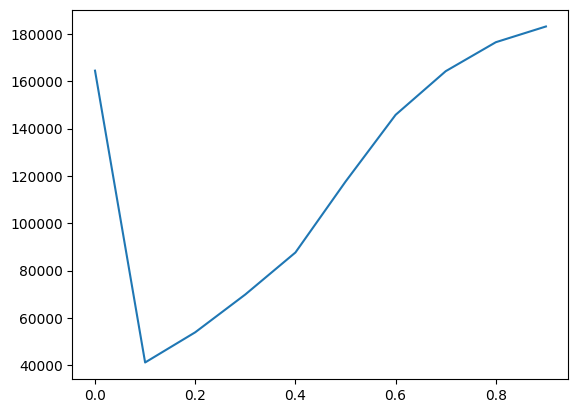

In [ ]:
import matplotlib.pyplot as plt
lista_valor_monetario = []
lista_range = []
for i in range(0, 10):
    y_proba = model.predict(x_teste).squeeze()
    y_pred_redes_threshold = (y_pred_redes > i/10).astype(int)
    confusio = confusion_matrix(y_teste, y_pred_redes_threshold)
    lista_valor_monetario.append((confusio[0][0] * 0)+(confusio[1][1] * 25)+(confusio[0][1]*10)+(confusio[1][0]*500))
    lista_range.append(i/10)
plt.plot(lista_range, lista_valor_monetario)

In [ ]:
modelos = {
    'logistic': LogisticRegression(),
    'random': RandomForestClassifier(),
    'gradient': GradientBoostingClassifier(),
    'svc': SVC(),
    'cat': CatBoostClassifier(),
    #'rede': Sequential()
}

In [ ]:
from sklearn.metrics import classification_report
lista_
for key,model in modelos.items():
    if key == 'rede':
        
    model = model
    model_treinado = model.fit(x_treino, y_treino)
    print('O modelo treinado e de:', key)
    print(key, model_treinado.score(x_teste, y_teste))
    print(classification_report(y_teste, model.predict(x_teste)))
    print('----------------------------------------------------')
        
        

In [ ]:
model = RandomForestClassifier()
model = model.fit(x_treino, y_treino)

In [ ]:
from sklearn.model_selection import cross_val_predict
y_probas_forest = cross_val_predict(model, x_treino, y_treino, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores = cross_val_predict(model, x_treino, y_treino, cv=3)

In [ ]:
y_scores.shape

(59606,)

In [ ]:
# score = proba of positive class
fpr, tpr, thresholds = roc_curve(y_treino,y_scores)

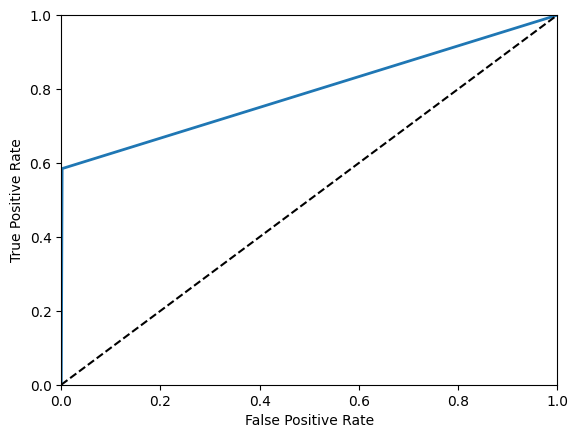

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
y_pred = model.predict(x_teste)

In [ ]:

y_predict_proba = model.predict_proba(x_treino)

In [ ]:
y_proba = model.predict_proba(x_treino)
y_proba

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
y_pred_prob_threshold = (y_proba[:, 1] >= 0.7).astype(int)
confusion_matrix(y_treino, y_pred_prob_threshold)

array([[58609,     0],
       [  126,   871]])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_teste)
y_proba = model.predict_proba(x_teste)
y_pred_prob_threshold = (y_proba[:, 1] >= 0.3).astype(int)
confusio = confusion_matrix(y_teste, y_pred_prob_threshold)
confusio

array([[15428,    90],
       [   73,   300]])

In [ ]:
lista_valor_monetario = []
for i in range(0, 10):
    y_proba = model.predict_proba(x_teste)
    y_pred_prob_threshold = (y_proba[:, 1] >= i/10).astype(int)
    confusio = confusion_matrix(y_teste, y_pred_prob_threshold)
    lista_valor_monetario.append((confusio[0][0] *0)+(confusio[1][1] * 25)+(confusio[0][1]*10)+(confusio[1][0]*500))

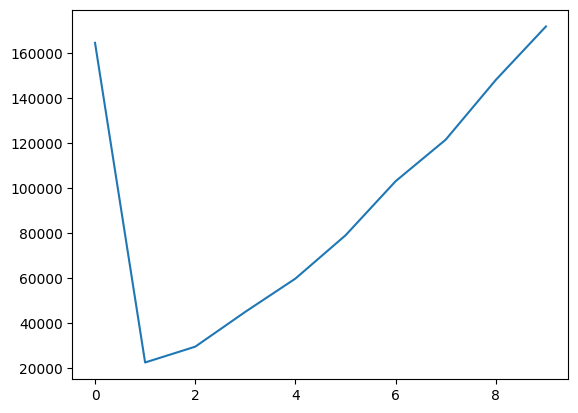

In [ ]:
plt.plot(range(0, 10), lista_valor_monetario)

In [ ]:
confusio

array([[15496,    22],
       [  152,   221]])

In [ ]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15518
           1       0.91      0.59      0.72       373

    accuracy                           0.99     15891
   macro avg       0.95      0.80      0.86     15891
weighted avg       0.99      0.99      0.99     15891

